# Compétition 1 : Prédiction de la Qualité de la Bière 🍺

Ce notebook fournit du code de démarrage pour la compétition de prédiction de la qualité de la bière. Pour les instructions complètes, l'énoncé du problème et les critères de notation, veuillez vous référer au fichier **README.md**.

**Résumé rapide** : Vous allez construire un modèle de classification pour prédire la qualité de la bière (scores 1-10) basé sur des propriétés chimiques. Soumettez vos prédictions sur [Kaggle](https://www.kaggle.com/competitions/ift-6390-ift-3395-beer-quality-prediction/).

## Importer les Dépendances

In [348]:
# Importer les bibliothèques requises
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Charger et Explorer les Données

In [349]:
# Charger les données d'entraînement
train_df = pd.read_csv('data/train.csv', delimiter=';')

print(f"Forme des données d'entraînement : {train_df.shape}")
print(f"Nombre d'échantillons (n) : {train_df.shape[0]}")
print(f"Nombre de caractéristiques (d) : {train_df.shape[1] - 1}")  # Soustraire 1 pour la colonne cible
print(f"Colonnes : {list(train_df.columns)}")
print("\nPremières lignes :")
print(train_df.head())

# Vérifier les types de données et informations de base
print("\nTypes de données et informations :")
print(train_df.info())

####################################################################
###############   À compléter   ####################################
####################################################################

Forme des données d'entraînement : (4469, 15)
Nombre d'échantillons (n) : 4469
Nombre de caractéristiques (d) : 14
Colonnes : ['id', 'beer_style', 'bitterness_IBU', 'diacetyl_concentration', 'lactic_acid', 'final_gravity', 'sodium', 'free_CO2', 'dissolved_oxygen', 'original_gravity', 'pH', 'gypsum_level', 'alcohol_ABV', 'fermentation_strength', 'quality']

Premières lignes :
   id beer_style  bitterness_IBU  diacetyl_concentration  lactic_acid  \
0   0       Pale           7.997                   0.446        0.280   
1   1       Pale           6.906                   0.222        0.303   
2   2      Brown           7.183                   0.636        0.071   
3   3       Pale           6.403                   0.242        0.260   
4   4      Brown           7.917                   0.182        0.347   

   final_gravity  sodium  free_CO2  dissolved_oxygen  original_gravity     pH  \
0         10.803   0.052    24.999           157.026             0.995  3.057   
1          6.305   0.

## Prétraitement des Données

Implémentez votre pipeline de prétraitement (voir README.md pour des suggestions).

In [350]:


df = pd.read_csv('data/train.csv', delimiter=';')
descriptive_stats = df.describe(include='all').T

print("--- Statistiques Descriptives (Distribution, Min, Max, Moyenne) ---")
print(descriptive_stats)

print("\n--- Types de Données (Aperçu de la distribution) ---")
print(df.info())

print("\n--- Valeurs Manquantes par Colonne ---")
print(df.isnull().sum())


--- Statistiques Descriptives (Distribution, Min, Max, Moyenne) ---
                         count unique   top  freq        mean          std  \
id                      4469.0    NaN   NaN   NaN      2234.0  1290.233506   
beer_style                4469      5  Pale  1704         NaN          NaN   
bitterness_IBU          4469.0    NaN   NaN   NaN    7.235609     1.296424   
diacetyl_concentration  4469.0    NaN   NaN   NaN     0.33864     0.163701   
lactic_acid             4469.0    NaN   NaN   NaN    0.317996     0.145221   
final_gravity           4469.0    NaN   NaN   NaN    5.506593     4.741626   
sodium                  4469.0    NaN   NaN   NaN    0.055572     0.033916   
free_CO2                4469.0    NaN   NaN   NaN   30.744267    18.011711   
dissolved_oxygen        4469.0    NaN   NaN   NaN  116.383056    56.441889   
original_gravity        4469.0    NaN   NaN   NaN    0.994855     0.010509   
pH                      4469.0    NaN   NaN   NaN    3.217238     0.161431

In [351]:
def preprocessing_caracterisques(processed_df): 
# ========================================= Nouvelles features =========================================
    processed_df['gas_balance'] = processed_df['free_CO2'] / (processed_df['dissolved_oxygen'])
    processed_df['mineral_strength'] = processed_df['gypsum_level'] * processed_df['sodium']
    processed_df['fermentation_ratio'] = processed_df['fermentation_strength'] / (processed_df['alcohol_ABV'] )
    processed_df['acid_balance'] = processed_df['lactic_acid'] / (processed_df['pH']) # out 
    processed_df['acid_x_gas'] = processed_df['acid_balance'] * processed_df['gas_balance']
    processed_df['gravity_drop'] = processed_df['original_gravity'] - processed_df['final_gravity'] # out 
    processed_df['log_gravity_drop'] = np.log1p(processed_df['gravity_drop'].clip(lower=0))
    # processed_df = processed_df.drop(columns=['bitterness_IBU','diacetyl_concentration'], errors='ignore')
    # Features supprimées : ['final_gravity', 'acid_balance', 'gravity_drop', 'dissolved_oxygen', 'pH', 'id', 'beer_style']
    # Features supprimées : ['final_gravity', 'acid_balance', 'fermentation_strength', 'gravity_drop', 'dissolved_oxygen', 'pH', 'id', 'beer_style']
    #processed_df = processed_df.drop(columns=['final_gravity', 'acid_balance', 'fermentation_strength', 'gravity_drop', 'dissolved_oxygen', 'pH', 'beer_style'], errors='ignore')
    
    #========================================= Legacy features =========================================
    # processed_df['log_final_gravity'] = np.log1p(processed_df['final_gravity']) # out
    # processed_df['acid_balance'] = processed_df['lactic_acid'] / (processed_df['pH'] + 1e-5) # out 
    # processed_df['alcohol_efficiency'] = processed_df['alcohol_ABV'] / (processed_df['gravity_drop'] + 1e-5) # out 
    # processed_df['residual_sugar_index'] = processed_df['final_gravity'] / (processed_df['original_gravity'] + 1e-5) # out 
    # processed_df['lactic_intensity'] = processed_df['lactic_acid'] * processed_df['fermentation_strength'] # out 
    # processed_df['acid_x_gravity'] = processed_df['acid_balance'] * processed_df['gravity_drop'] # out
    # processed_df['sqrt_alcohol_eff'] = np.sqrt(processed_df['alcohol_efficiency'].clip(lower=0)) # out 

    return processed_df

In [352]:
def get_highly_correlated_features(df, threshold):
    corr_matrix = df.corr(numeric_only=True).abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    high_corr_features = [
        column for column in upper.columns 
        if any(upper[column] > threshold)
    ]

    return high_corr_features

def get_lowly_correlated_features(df, threshold):
    if 'quality' not in df.columns:
        return []
    corr_target = df.corr(numeric_only=True)['quality'].abs()
    low_corr_features = corr_target[corr_target < threshold].index.tolist()
    return low_corr_features

In [353]:
def drop_by_correlation(df, high_corr_threshold=0.95, low_corr_threshold=0.05):

    low_corr_features = get_lowly_correlated_features(df, low_corr_threshold)
    high_corr_features = get_highly_correlated_features(df.drop(columns=['quality'], errors='ignore'), high_corr_threshold)

    features_to_drop = list(set(low_corr_features + high_corr_features))
    df = df.drop(columns=features_to_drop, errors='ignore')

    print("Features supprimées :", features_to_drop)

    return df, features_to_drop

In [354]:
def missing_or_infinite_gestion(rl_df) -> pd.DataFrame:
# Gestion des valeurs manquantes et infinies
    rl_df = rl_df.replace([np.inf, -np.inf], np.nan)
    rl_df = rl_df.dropna(subset=['quality'])
    rl_df = rl_df.fillna(rl_df.mean())
    return rl_df

In [355]:
def visualize_distributions(df) -> None:
    corr = df.corr(numeric_only=True)
    sns.heatmap(corr, cmap='coolwarm', center=0)
    sns.pairplot(df[['lactic_acid','pH','alcohol_ABV','final_gravity','quality']], hue='quality')
    plt.figure(figsize=(10,6))
    sns.heatmap(df[['gravity_drop','acid_balance','gas_balance','quality']].corr(),
                annot=True, cmap='coolwarm', center=0)
    plt.title("Corrélations des nouvelles features avec la qualité")
    plt.show()

    corr2 = df[['acid_x_gas','log_gravity_drop','quality']].corr()
    sns.heatmap(corr2, annot=True, cmap='coolwarm', center=0)
    plt.title("Corrélations des features non linéaires avec la qualité")
    plt.show()


In [356]:
####################################################################
###############   À compléter   ####################################
####################################################################

# Encodage de la variable catégorielle 'beer_style'
le = LabelEncoder()
train_df['beer_style'] = le.fit_transform(train_df['beer_style'])

# La classification officiel est entre 4 et 8, on se concentre donc sur cette plage compte tenu que les classes
# en dehors sont très peu représentées ou possiblement du bruit
rl_df = train_df[train_df['quality'].between(4,8)]
rl_df = preprocessing_caracterisques(rl_df)

## Decommenter pour voir les corrélations entre les features et la qualité
# visualize_distributions(rl_df)

rl_df, dropped_features = drop_by_correlation(rl_df)
rl_df = missing_or_infinite_gestion(rl_df)






Features supprimées : ['id', 'dissolved_oxygen', 'pH', 'gravity_drop', 'final_gravity', 'acid_balance', 'beer_style']


/var/folders/y5/5rmdtyp17yz4dz_hjr0z9d600000gn/T/ipykernel_92253/2716141933.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['gas_balance'] = processed_df['free_CO2'] / (processed_df['dissolved_oxygen'])
/var/folders/y5/5rmdtyp17yz4dz_hjr0z9d600000gn/T/ipykernel_92253/2716141933.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['mineral_strength'] = processed_df['gypsum_level'] * processed_df['sodium']
/var/folders/y5/5rmdtyp17yz4dz_hjr0z9d600000gn/T/ipykernel_92253/2716141933

## Préparer les Données d'Entraînement et de Validation

Divisez vos données en ensembles d'entraînement et de validation.

In [357]:
####################################################################
###############   À compléter   ####################################
####################################################################
# Préparation des données pour le modèle


if 'id' in rl_df.columns:
    rl_df =rl_df.drop(columns=['id'])

X = rl_df.drop(columns=['quality'])
y = rl_df['quality']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


## Entraîner les Modèles

Entraînez et comparez plusieurs modèles d'apprentissage automatique.

In [358]:
"""
def knnModel():
    for k in range(1, 100):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        print(f"k={k}, accuracy={accuracy_score(y_val, y_pred):.4f}")

    knn = KNeighborsClassifier(
        n_neighbors=27,
        weights='distance',
        metric='euclidean'
    )

    knn.fit(X_train, y_train)
    {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}

"""

'\ndef knnModel():\n    for k in range(1, 100):\n        model = KNeighborsClassifier(n_neighbors=k)\n        model.fit(X_train, y_train)\n        y_pred = model.predict(X_val)\n        print(f"k={k}, accuracy={accuracy_score(y_val, y_pred):.4f}")\n\n    knn = KNeighborsClassifier(\n        n_neighbors=27,\n        weights=\'distance\',\n        metric=\'euclidean\'\n    )\n\n    knn.fit(X_train, y_train)\n    {\'class_weight\': \'balanced\', \'max_depth\': 10, \'min_samples_split\': 2, \'n_estimators\': 50}\n\n'

In [ ]:


rf = RandomForestClassifier(
    n_estimators=50, 
    max_depth=10, 
    class_weight='balanced',
    min_samples_split=2, 
    random_state=42)
rf.fit(X_train_scaled, y_train)
# rf.fit(X_train_smote, y_train_smote)



RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=50,
                       random_state=42)

In [360]:

"""
from sklearn.model_selection import GridSearchCV

# Recherche des hyperparamètres pour la régression logistique

param_grid = {
    'C': [0.01, 0.1, 1, 5, 10, 20, 50],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(
    LogisticRegression(max_iter=2000, multi_class='multinomial'),
    param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Best F1_macro:", grid.best_score_)
"""

'\nfrom sklearn.model_selection import GridSearchCV\n\n# Recherche des hyperparamètres pour la régression logistique\n\nparam_grid = {\n    \'C\': [0.01, 0.1, 1, 5, 10, 20, 50],\n    \'penalty\': [\'l2\'],\n    \'solver\': [\'lbfgs\', \'saga\'],\n    \'class_weight\': [None, \'balanced\']\n}\n\ngrid = GridSearchCV(\n    LogisticRegression(max_iter=2000, multi_class=\'multinomial\'),\n    param_grid,\n    scoring=\'f1_macro\',\n    cv=5,\n    n_jobs=-1\n)\n\ngrid.fit(X_train, y_train)\nprint("Best parameters:", grid.best_params_)\nprint("Best F1_macro:", grid.best_score_)\n'

In [361]:
"""
Class_weight_manual = {4: 22.0, 5: 0.1, 6: 0.1, 7: 3.0, 8: 25.0}

svm = SVC(C=50.0, 
        kernel='rbf', 
        gamma=0.1,
        class_weight=Class_weight_manual, 
        random_state=42
        )

svm.fit(X_train, y_train)
"""

"\nClass_weight_manual = {4: 22.0, 5: 0.1, 6: 0.1, 7: 3.0, 8: 25.0}\n\nsvm = SVC(C=50.0, \n        kernel='rbf', \n        gamma=0.1,\n        class_weight=Class_weight_manual, \n        random_state=42\n        )\n\nsvm.fit(X_train, y_train)\n"

In [362]:
####################################################################
###############   À compléter   ####################################
####################################################################

# Logistic Regression Model

log_reg = LogisticRegression(
    penalty='l2',
    multi_class='multinomial',
    solver='saga',
    C=50.0,
    max_iter=10000,
    class_weight='balanced',
    #l1_ratio=0.8
)
log_reg.fit(X_train_scaled, y_train)
# log_reg.fit(X_train_smote, y_train_smote)




/opt/homebrew/anaconda3/envs/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=50.0, class_weight='balanced', max_iter=10000,
                   multi_class='multinomial', solver='saga')

## Évaluer les Modèles

Analysez la performance de votre meilleur modèle (voir README.md pour les directives d'évaluation).

Exactitude: 0.37682789651293586
              precision    recall  f1-score   support

           4       0.08      0.57      0.15        23
           5       0.58      0.52      0.55       299
           6       0.65      0.24      0.35       397
           7       0.34      0.40      0.37       151
           8       0.07      0.53      0.13        19

    accuracy                           0.38       889
   macro avg       0.34      0.45      0.31       889
weighted avg       0.54      0.38      0.41       889



/opt/homebrew/anaconda3/envs/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/anaconda3/envs/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/anaconda3/envs/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


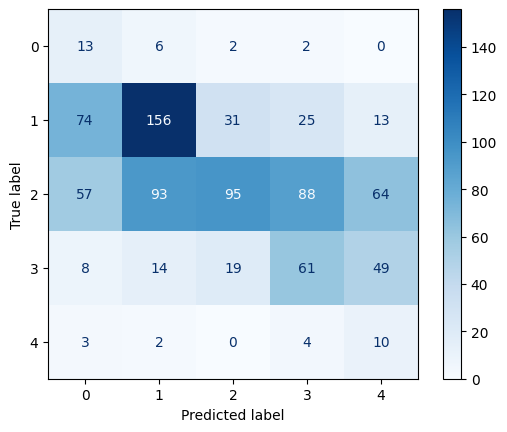

In [ ]:
####################################################################
###############   À compléter   ####################################
####################################################################
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = log_reg.predict(X_val_scaled)
#y_pred = rf.predict(X_val_scaled)
print("Exactitude:", accuracy_score(y_val,y_pred))
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

## Générer les Prédictions pour la Soumission Kaggle

Créez un fichier CSV avec les colonnes : `id` et `quality` (voir README.md pour les détails du format).

In [364]:

####################################################################
###############   À compléter   ####################################
####################################################################

# Charger les données de test
test_df = pd.read_csv("data/test.csv", sep=";")

# Encodage du style avec le même LabelEncoder
test_df['beer_style'] = le.transform(test_df['beer_style'])

test_df = preprocessing_caracterisques(test_df)

test_df = test_df.replace([np.inf, -np.inf], np.nan)
test_df = test_df.fillna(test_df.mean())

# Sauvegarde de l'id pour la soumission
ids = test_df['id']
X_test = test_df.drop(columns=['id'])

# Assure que les colonnes du test correspondent à celles du train
for col in X.columns:
    if col not in X_test.columns:
        test_df[col] = 0
X_test = test_df[X.columns]
print('les colonnes:', X_test.columns)
X_test_scaled = scaler.transform(X_test)

# Prédiction sur le test set
y_pred = log_reg.predict(X_test_scaled)

print("Test shape:", X_test_scaled.shape)

submission = pd.DataFrame({
    'id': ids,
    'quality': y_pred.astype(int)
})

# Sauvegarde
submission.to_csv("ift3395_YamirPoldoSilvaV8.csv", index=False)

print(submission.head())

df1 = pd.read_csv("ift3395_YamirPoldoSilvaV5.csv")
df2 = pd.read_csv("ift3395_YamirPoldoSilvaV8.csv")

comparison = df1.compare(df2)
print(comparison)
print("Nombre de différences :", len(comparison))



les colonnes: Index(['bitterness_IBU', 'diacetyl_concentration', 'lactic_acid', 'sodium',
       'free_CO2', 'original_gravity', 'gypsum_level', 'alcohol_ABV',
       'fermentation_strength', 'gas_balance', 'mineral_strength',
       'fermentation_ratio', 'acid_x_gas', 'log_gravity_drop'],
      dtype='object')
Test shape: (511, 14)
   id  quality
0   0        6
1   1        5
2   2        8
3   3        7
4   4        8
    quality      
       self other
2       7.0   8.0
4       7.0   8.0
14      4.0   7.0
17      7.0   8.0
18      4.0   7.0
..      ...   ...
504     5.0   4.0
505     5.0   6.0
508     7.0   4.0
509     6.0   5.0
510     7.0   6.0

[140 rows x 2 columns]
Nombre de différences : 140


/opt/homebrew/anaconda3/envs/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/anaconda3/envs/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/anaconda3/envs/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


---
Bonne chance pour la compétition ! 🍺
